 # Converting Text Files into csv

In [ ]:
import csv
# Open the text file for reading
with open('/home/govind/project/data/sad.txt', 'r') as file:
    lines = file.readlines()

# Initialize a list to store data
data = []

# Iterate through each line in the text file
for line in lines:
    # Split the line by tabs
    parts = line.split('\t')
    # Extract sample number, label, and text
    sample_number = parts[0]
    text = parts[1]
    label = 3  # Assigning label as 0
    # Append data to the list
    data.append((sample_number, label, text))

# Write the data to a CSV file
with open('sad.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Sample Number', 'Label', 'Text']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for sample_number, label, text in data:
        writer.writerow({'Sample Number': sample_number, 'Label': label, 'Text': text})


# Converting Mulitple CSVS into Single CSV 

In [ ]:
import os
import pandas as pd

# List all CSV files in the directory
csv_files = [file for file in os.listdir() if file.endswith('.csv')]

# Initialize an empty DataFrame to store combined data
combined_data = pd.DataFrame()

# Iterate through each CSV file
for file in csv_files:
    # Read the CSV file
    data = pd.read_csv(file)
    # Remove the sample_number column
    data.drop(columns=['Sample Number'], inplace=True)
    # Concatenate data to the combined DataFrame
    combined_data = pd.concat([combined_data, data], ignore_index=True)

# Save the combined data to a new CSV file
combined_data.to_csv('combined_data.csv', index=False)


# Importing Required Libraries

In [4]:
import pandas as pd
import numpy as np
import pickle
import itertools
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from IPython.display import display
import matplotlib.pyplot as plt



# Reading CSV file and creating Data Frame

In [5]:
df = pd.read_csv('/home/govind/project/data/combined_data.csv')

In [6]:
df.head()

,Label,Text
0,1,I feel like I am drowning. #depression #anxiet...
1,1,I get so nervous even thinking about talking t...
2,1,I lost my blinders .... #panic
3,1,I feel like I am drowning. #depression #falur...
4,1,This is the scariest American Horror Story out...


# Plotting the Distribution of Different Classes

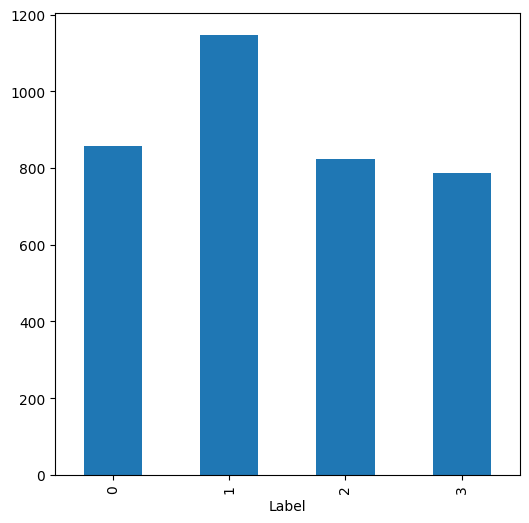

In [7]:
fig = plt.figure(figsize=(6,6))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

# Creating Embeddings for Text Sentences

In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Text).toarray()

labels = df.Label
print(features.shape)
print(labels.shape)

(3613, 1212)
(3613,)


# Splitting the Data into Test, Train

In [9]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

# Creating Labels Dictionary

In [10]:
emotion_dict = {'anger': 0,
                'fear': 1,
                'joy': 2,
                'sadness': 3}

emo_keys = list(['anger', 'fear', 'joy', 'sadness'])



# Function for Calculating Confusion Matrix

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# One Hot encoding for True Labels

In [12]:
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

# Function for calculating Metrics

In [13]:
def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

# Training SVM Model 

In [14]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)


/home/govind/pvenv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

# Performance of Trianed Model on Test Data

Test Set Accuracy =  0.812
Test Set F-score =  0.810
Test Set Precision =  0.813
Test Set Recall =  0.809
Confusion matrix, without normalization
[[143  15   4  11]
 [ 13 182   8  18]
 [  5  11 150   7]
 [ 16  23   5 112]]


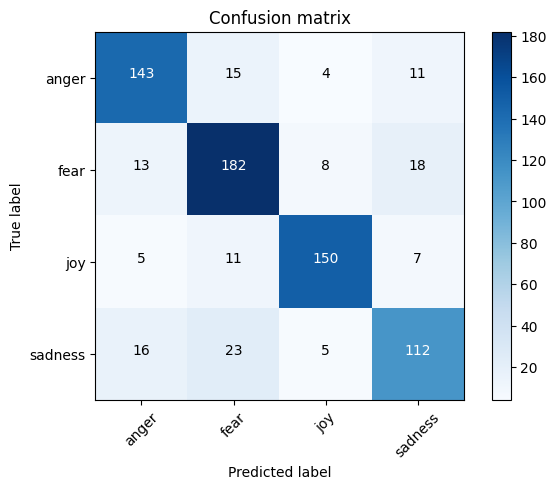

In [15]:
# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())



# Saving the Pretrained Model in Binary File

In [ ]:
with open('/home/govind/project/models/text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)